# Importando bibliotecas

In [403]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from arch.unitroot import PhillipsPerron as pp
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.simplefilter('ignore')
%matplotlib inline
sns.set_style("whitegrid")
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

# 1. Importando base de dados formatada

## 1.1 Tratando os dados internos

In [404]:
# conversor de data
dt_parse = lambda dates: dt.strptime(dates, '%Y-%m-%d %H:%M:%S')
# importação de csv com os dados e indexação deles pela data
data = pd.read_csv('data/transformed/2000_2021_Brazilian_North_Region_hourly_MWmed_hydroelectric_power_series.csv',
                   header=0, names=['index','value', 'date'], parse_dates=True, index_col='index', date_parser=dt_parse)
# definição dos tipos de dados
data['value'] = data['value'].astype(float)
data['date'] = data['date'].astype('datetime64')
data = data[data['value'] > 0.0]
# adição de 'tabelas' para melhor algumas filtragens
data['year']  = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day']   = data['date'].dt.day
data['hour'] = data['date'].dt.hour
data['weekday'] = data['date'].dt.weekday
data.head()

,value,date,year,month,day,hour,weekday
index,,,,,,,
2000-01-01 00:00:00,2422.5,2000-01-01 00:00:00,2000,1,1,0,5
2000-01-01 01:00:00,2769.3,2000-01-01 01:00:00,2000,1,1,1,5
2000-01-01 02:00:00,3124.7,2000-01-01 02:00:00,2000,1,1,2,5
2000-01-01 03:00:00,3154.6,2000-01-01 03:00:00,2000,1,1,3,5
2000-01-01 04:00:00,3121.8,2000-01-01 04:00:00,2000,1,1,4,5


# 2. Exploração de dados analíticos

## 2.1 Dados no tempo / Gráfico geral

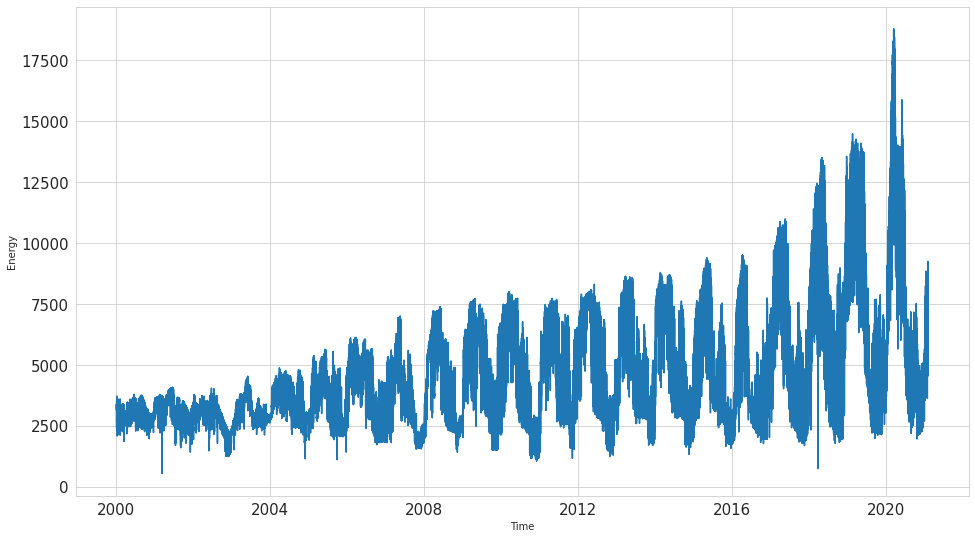

In [405]:
plt.rcParams["figure.figsize"] = [16,9] # dimenção do gráfico
plt.ylabel('Energy') #y
plt.xlabel('Time') #x
plt.plot(data['value']) # impressão dos dados

## 2.2 Informações estatisticas gerais dos dados

In [406]:
describe = data['value'].describe() # descrição dos dados estatisticos
mode = data['value'].mode() #moda
variant = data['value'].var() #variancia
print(f"Variant: {variant}")
print(f"Mode: {mode}")
for key in describe.keys():
    print(f"{key}: {describe[key]}") #outros dados

Variant: 6149418.358946173
Mode: 0    3045.0
dtype: float64
count: 184782.0
mean: 4619.7879699835485
std: 2479.802080599614
min: 539.5
25%: 2921.5
50%: 3694.1499999999996
75%: 5896.09225
max: 18793.893


## 2.3 Curva normal do gráfico

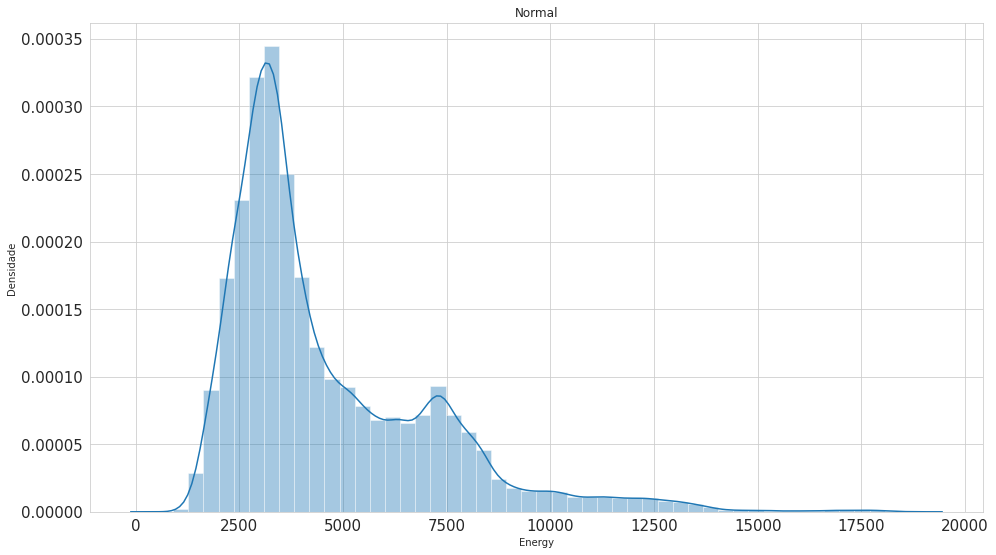

In [407]:
ax = sns.distplot(data['value'], kde=True) # criando a normal
ax.set(xlabel= 'Energy', ylabel='Densidade', title='Normal')
plt.show()

## 2.4 Line

Permite ver dados dos meses ao decorrer do tempo

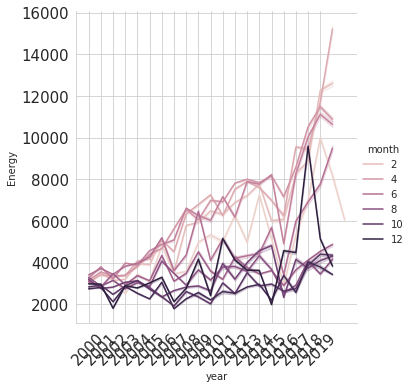

In [408]:
# amostragem de dados por mês em forma de linha do ano de 2000 a 2021
sns.relplot(data=data, x="year", y="value", hue="month", kind='line')
plt.ylabel('Energy')
plt.xticks(np.arange(2000, 2020, 1), rotation=45)
plt.show()
# data.hist(figsize=(15,12), column='value', by='month', bins=25)

## 2.5 Box-plot

Permiter ver as medianas e os quartis. Importante para ver como os dados estão distribuidos por ano.

Text(0, 0.5, 'Energy')

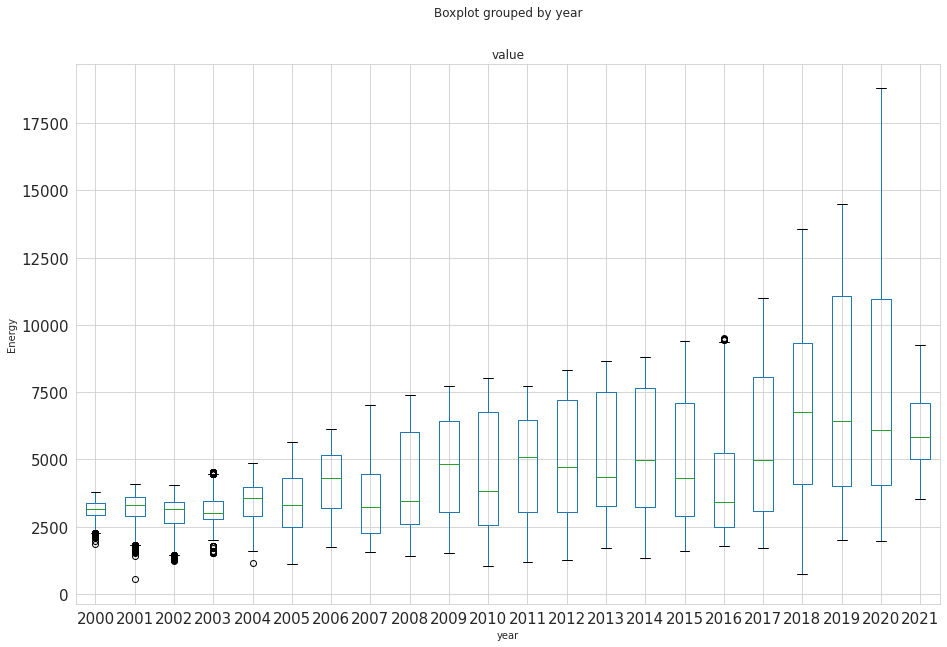

In [409]:
data.boxplot(figsize=(15,10), by='year', column=['value']) # por ano
plt.ylabel('Energy')

# 3. Transformata

## 3.1 Transformada Box-Cox

A transformação de Box-Cox faz uma curva ficar normalmente distribuida, assim permitindo o usuario a fazer uma serie de testes que só podem ser usados em séries distribuidas assim.

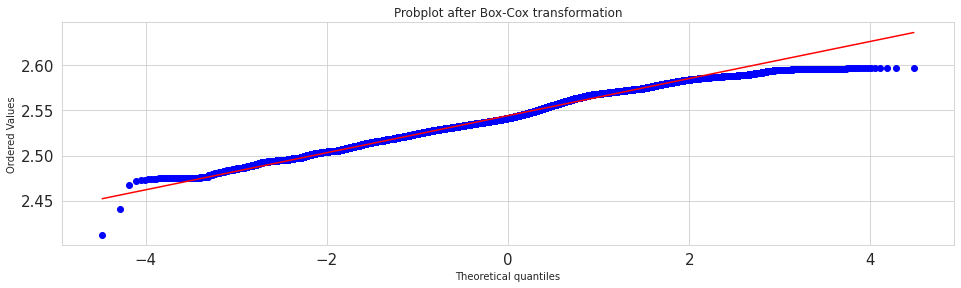

In [410]:
fig = plt.figure()
# ax1 = fig.add_subplot(211)
x = stats.loggamma.rvs(5, size=500) + 5
# prob = stats.probplot(data['value'], dist=stats.norm, plot=ax1)
# ax1.set_xlabel('')
# ax1.set_title('Probplot against normal distribution')
ax2 = fig.add_subplot(212)
xt, _ = stats.boxcox(data['value'])
prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
ax2.set_title('Probplot after Box-Cox transformation')
plt.show()

## 3.2 Transformada Log

A transformação Log diminui o vies dos dados.

None


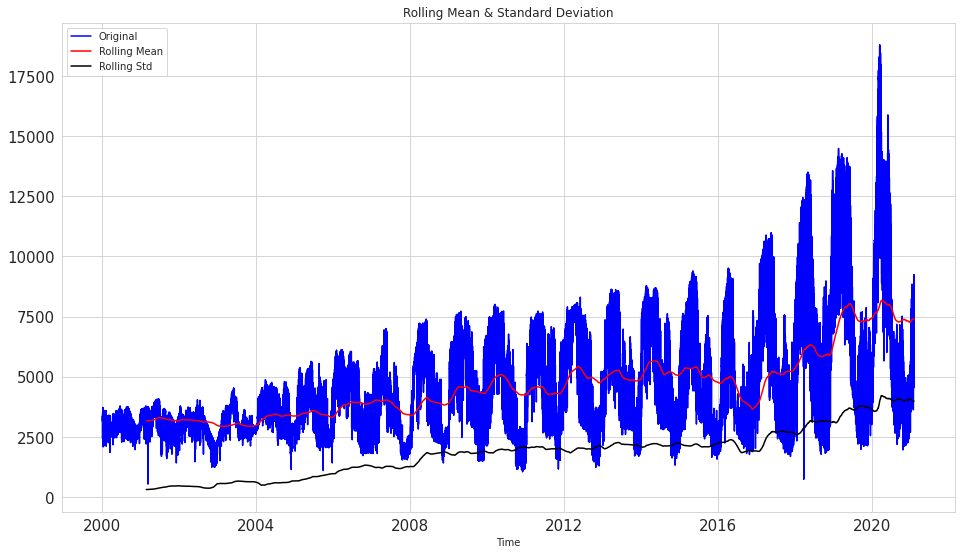

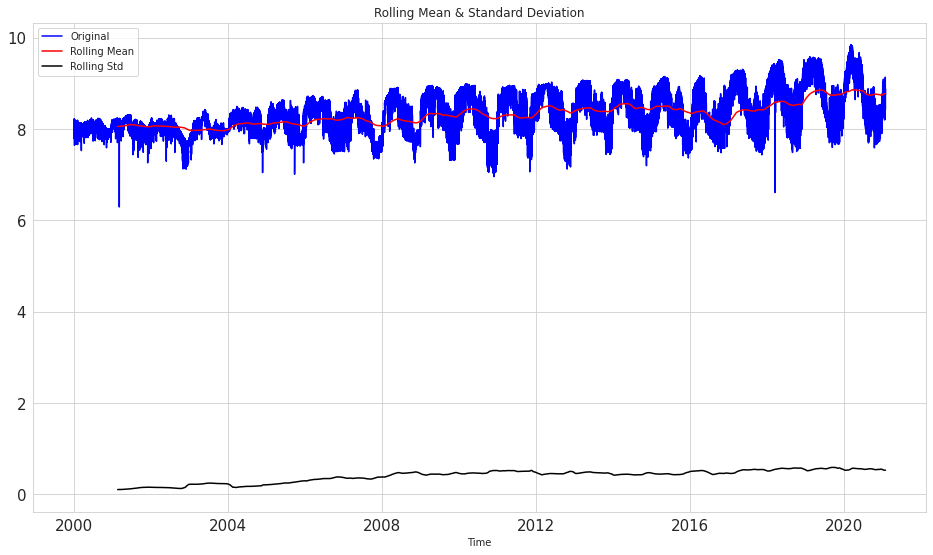

In [411]:
v_log = np.log(data['value']) # criando a transformada ln
data = data.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
value = data['value']
print(pd.infer_freq(value.index))

def test_stationarity(timeseries, window_size=10000):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window_size).mean() # media da transformada
    rolstd  = timeseries.rolling(window_size).std() # desvio

    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.xlabel('Time')
    plt.show(block=False)

test_stationarity(data['value'])

test_stationarity(v_log)
# v_log.to_csv('data/exported/transformed_log.csv')

# 4. Decomposição

Divide serie temporal em tendencia, sazonalidade e aleatoriedade.

- Tendencia: Permite checar se serie temporal tem um padrão de aumento/diminuição dos valores com o tempo;
- Sazonalidade: Representa a variação recorrente(anual, mensal, semanal, ...);

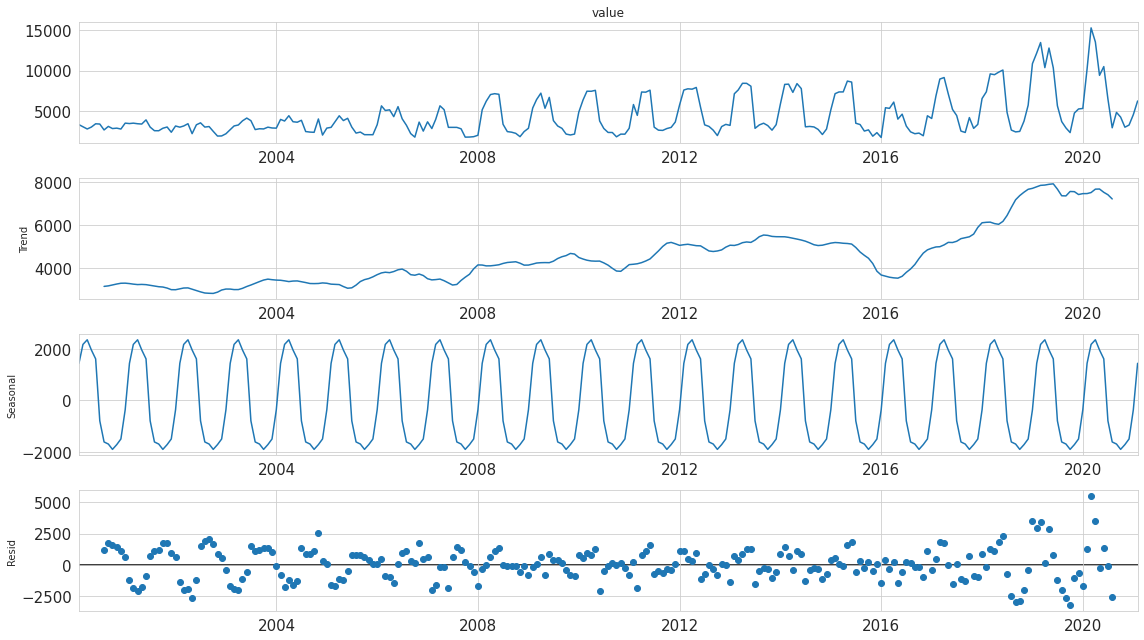

In [412]:
data.sort_index(inplace=True)
data.drop(['date', 'year', 'month', 'day', 'hour', 'weekday'],inplace=True,axis=1)

decomposition = sm.tsa.seasonal_decompose(data.value.asfreq('m'), model='additive')
plt.rcParams["figure.figsize"] = [16,9]
fig = decomposition.plot()

# 5. Testes de estacionaridades

Finalidade: Determinar estacionariedade de uma série temporal.

## 5.1 Teste KPPS

In [413]:
series = data['value']
statistic, p, lags, values = sm.tsa.stattools.kpss(series, 'c')
print(f"Test statistic: {statistic}")
print(f"P Value: {p}")
print(f"Lags: {lags}")
for key in values.keys():
    print(f"{key}: {values[key]}")

Test statistic: 55.819347135610435
P Value: 0.01
Lags: 79
10%: 0.347
5%: 0.463
2.5%: 0.574
1%: 0.739


## 5.2 Teste PP

In [414]:
pp(series)

Test Statistic,-19.055
P-value,0.000
Lags,79


## 5.3 Teste de Dickey Fuller

In [415]:
statistic, p, lags, dont_know, values, test = sm.tsa.adfuller(series.head(10000))
print(f"Test statistic: {statistic}")
print(f"P Value: {p} ???")
print(f"Lags: {lags}")
for key in values.keys():
    print(f"{key}: {values[key]}")

Test statistic: -6.5849014467475175
P Value: 7.356345420225857e-09 ???
Lags: 33
1%: -3.431006330034765
5%: -2.861830058724424
10%: -2.566924393122448


# 6. Persistência

O que o modelo de persistencia faz?

O modelo de persistencia fala que o valor de n é igual ao de n + 1.

In [416]:
split_date = '1/1/2019 12:00:00 AM'
test  = data[split_date : ]
train = data[ : split_date]

test.head()

,value
index,
2019-01-01 00:00:00,7297.073
2019-01-01 01:00:00,6900.449
2019-01-01 02:00:00,6869.606
2019-01-01 03:00:00,6856.405
2019-01-01 04:00:00,6853.338


#### Concatenate train and test series to plotting

In [417]:
train = train['value']
test = test['value']
series = pd.concat([train, test], axis=0)
series

index
2000-01-01 00:00:00    2422.500
2000-01-01 01:00:00    2769.300
2000-01-01 02:00:00    3124.700
2000-01-01 03:00:00    3154.600
2000-01-01 04:00:00    3121.800
                         ...   
2021-01-30 20:00:00    7217.682
2021-01-30 21:00:00    7187.145
2021-01-30 22:00:00    6658.727
2021-01-30 23:00:00    6529.498
2021-01-31 00:00:00    6279.152
Name: value, Length: 184783, dtype: float64

#### Prepare data

O resultado do modelo de persistencia da a baseline. Basicamente permite comparar outros modelos com o seu resultado para assim checar sua eficiencia.

Vantangens do modelo de persistencia:
- Simples
- Rapido
- Facil de replicar

In [418]:
def persistence(last_ob, n_steps):
    return [last_ob for i in range(n_steps)]


test = test.values
series = series.values
train = [x for x in train]

# Number of multi-step
n_steps = 24

# Store multi-step forecasts
forecasts = list()
forecasts_exp = list()

# Number of multi-step forecasts
n_forecasts = len(test) - n_steps + 1

# Walk-forward validation
for i in range(n_forecasts):
    # Make a multi-step forecast
    last_ob = train[-1]
    yhat = persistence(last_ob, n_steps)

    # Store the multi-step forecast
    forecasts.append(yhat)

    # Add actual observation to train for the next loop
    obs = test[i]
    train.append(obs)
    forecasts_exp.append([yhat[0], obs])

print("Ultimos 10 valores:")
for item in forecasts_exp[-10:]:
    print(f"Predito={item[0]}, Esperado={item[1]}") # valores de preditos e reais para comparação

Ultimos 10 valores:
Predito=9237.427, Esperado=8566.823
Predito=8566.823, Esperado=8271.562
Predito=8271.562, Esperado=8012.252
Predito=8012.252, Esperado=8290.312
Predito=8290.312, Esperado=8289.579
Predito=8289.579, Esperado=8273.642
Predito=8273.642, Esperado=7498.538
Predito=7498.538, Esperado=6300.131
Predito=6300.131, Esperado=5519.645
Predito=5519.645, Esperado=5425.253


#### Evaluate the forecasts

In [419]:
# Evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_steps,sum_mape=None):
    sum_rmse = 0
    sum_mape = 0
    for i in range(n_steps):
        # Picking the values from multi-step forecasts
        ypred_ts = [forecast[i] for forecast in forecasts]

        # Sliding window on test series
        ytrue_ts = test[i:len(ypred_ts)+i]
        rmse = sqrt(mean_squared_error(ytrue_ts, ypred_ts))
        mape = sqrt(mean_absolute_error(ytrue_ts, ypred_ts))
        sum_rmse += rmse
        sum_mape += mape
        print(f"t+{(i+1)} RMSE: {rmse} | MAPE: {mape}") #erros entre a predição e teste

    print(f"Média do RMSE: {sum_rmse/n_steps}")
    print(f"Média do MAPE: {sum_mape/n_steps}")

evaluate_forecasts(test, forecasts, n_steps)

t+1 RMSE: 409.6679707744369 | MAPE: 16.55848490749534
t+2 RMSE: 702.4252573745656 | MAPE: 22.139529810554485
t+3 RMSE: 930.8436093712165 | MAPE: 25.824477965838753
t+4 RMSE: 1123.278275355191 | MAPE: 28.678592987750363
t+5 RMSE: 1286.3788091984102 | MAPE: 30.94596152223561
t+6 RMSE: 1424.4259975880425 | MAPE: 32.76527105795663
t+7 RMSE: 1538.5519571245466 | MAPE: 34.207417399796604
t+8 RMSE: 1628.6314821337453 | MAPE: 35.30479717229406
t+9 RMSE: 1696.2535587357004 | MAPE: 36.102266997812166
t+10 RMSE: 1744.4603870372187 | MAPE: 36.62723227562776
t+11 RMSE: 1777.5107859972222 | MAPE: 36.94320247606573
t+12 RMSE: 1796.7560491423558 | MAPE: 37.124952385536204
t+13 RMSE: 1800.065064700899 | MAPE: 37.174247058107895
t+14 RMSE: 1792.0138367423424 | MAPE: 37.112864318855614
t+15 RMSE: 1772.0411287271495 | MAPE: 36.90255153258611
t+16 RMSE: 1736.9171166598487 | MAPE: 36.50127334964028
t+17 RMSE: 1685.2838250478333 | MAPE: 35.89243016260871
t+18 RMSE: 1617.0319445060563 | MAPE: 35.0388913123182

## 6.1 Predições com multiplos passos

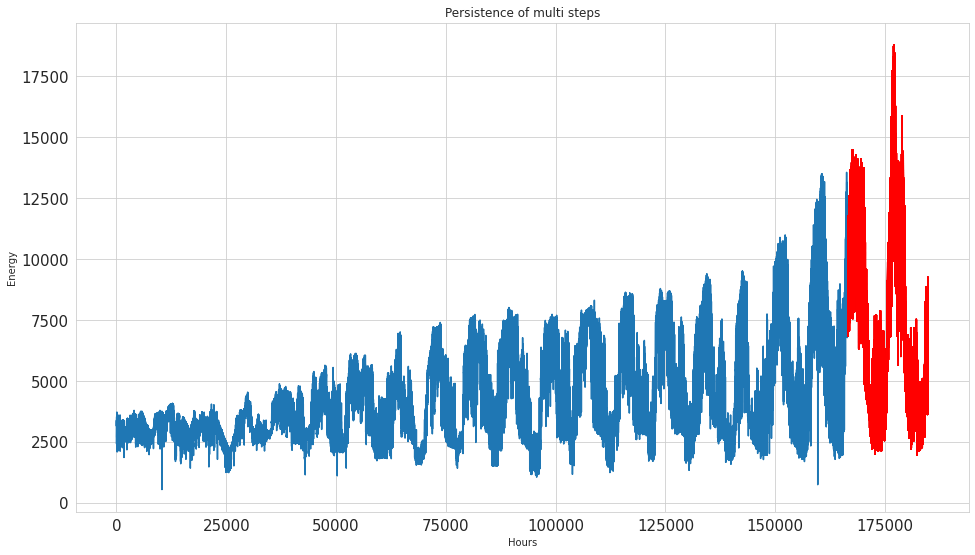

In [420]:
# Plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, test):
    # Plot the entire dataset in blue
    x_points = []
    y_points = []

    # Plot the forecasts in red
    for i in range(len(forecasts)):
        # Start offset for x-axis
        off_s = len(series) - len(test) + i - 1

        # End offset for x-axis
        off_e = off_s + len(forecasts[i]) + 1

        # Indexes of x-axis for multi-step forecasts
        xaxis = [x for x in range(off_s, off_e)]
        x_points.append(xaxis)
        # xaxis = np.array(xaxis)

        # Values of muti-step fotecasts
        yaxis = [series[off_s]] + forecasts[i]
        y_points.append(yaxis)
        # yaxis = np.array(yaxis)

        # sns.lineplot(data=xaxis, color='blue')
        # sns.lineplot(data=yaxis, color='red')

    # Show the final plot
    plt.plot(series)
    plt.plot(x_points, y_points, color='red')
    plt.ylabel('Energy')
    plt.xlabel('Hours')
    plt.title('Persistence of multi steps')
    plt.show()


plot_forecasts(series, forecasts, test)

## 6.2 Persistência com um passo

In [421]:
pred_exp = list()
predictions = list()
for i in range(len(test)):
    # Predict
    yhat = train[-1]
    # Store forecast in list of predictions
    predictions.append(yhat)
    # Add actual observation to train for the next loop
    obs = test[i]
    train.append(obs)
    pred_exp.append([yhat, obs])
    # print(f">Predicted={yhat}, Expected={obs}")

#### Performance

In [422]:
rmse = sqrt(mean_squared_error(test, predictions))
mape = sqrt(mean_absolute_error(test, predictions))
print('RMSE: %.3f | MAPE: %3.f' % (rmse, mape))
print("Ultimos 10 valores:")
for item in pred_exp[-10:]:
    print(f"Predito={item[0]}, Esperado={item[1]}")

RMSE: 409.812 | MAPE:  17
Ultimos 10 valores:
Predito=5702.289, Esperado=5645.473
Predito=5645.473, Esperado=5910.213
Predito=5910.213, Esperado=5967.413
Predito=5967.413, Esperado=6164.76
Predito=6164.76, Esperado=6887.143
Predito=6887.143, Esperado=7217.682
Predito=7217.682, Esperado=7187.145
Predito=7187.145, Esperado=6658.727
Predito=6658.727, Esperado=6529.498
Predito=6529.498, Esperado=6279.152


#### Predito vs Esperado

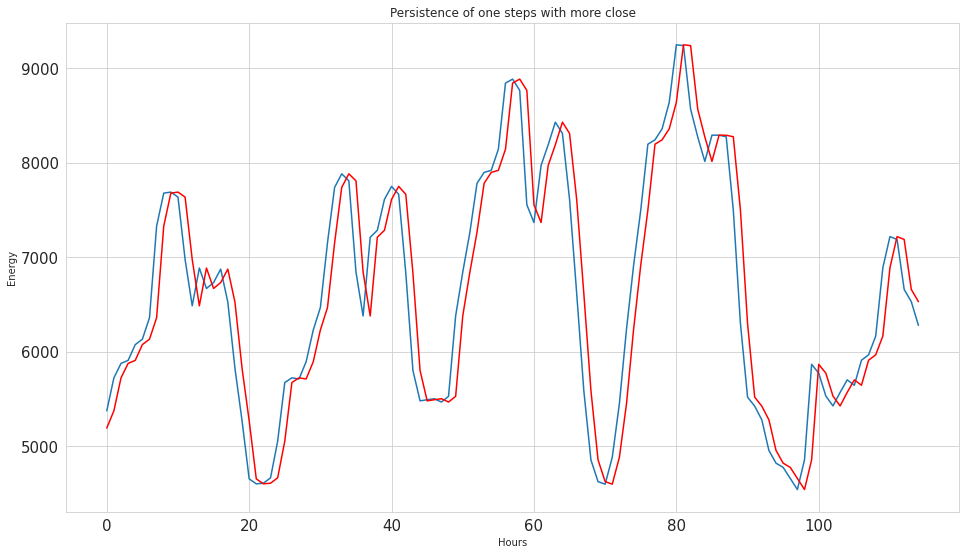

In [423]:
plt.plot(test[18150:])
plt.plot(predictions[18150:], color='red')
plt.ylabel('Energy')
plt.xlabel('Hours')
plt.title('Persistence of one steps with more close')
plt.show()

# 7. Suavização Exponencial


In [424]:
# precisa colocar as datas que o professor pediu para o treino e teste
split_date = '30/12/2020 12:00:00 AM'
test = data[split_date : ]
train = data['25/12/2020 12:00:00 PM' : split_date]

train_v = train['value']
test_v = test['value']

test_vv = test_v.values
train_vv = [x for x in train_v]

pred = list()
pred_exp = list()

## 7.1 Suavização Exponêncial Simples

t+1 RMSE: 383.0558814116704 | MAPE: 16.577073358771635
t+2 RMSE: 565.2901898516919 | MAPE: 20.381786635273752
Média RMSE: 474.17303563168116
Média MAPE: 18.47942999702269
Ultimos 10 valores:
Predito=5536.121399293174, Esperado=5702.289
Predito=5635.82195971727, Esperado=5645.473
Predito=5641.612583886908, Esperado=5910.213
Predito=5802.772833554764, Esperado=5967.413
Predito=5901.556933421905, Esperado=6164.76
Predito=6059.478773368763, Esperado=6887.143
Predito=6556.077309347505, Esperado=7217.682
Predito=6953.040123739002, Esperado=7187.145
Predito=7093.503049495601, Esperado=6658.727
Predito=6832.63741979824, Esperado=6529.498


Text(0.5, 1.0, 'Holt Method with multi steps')

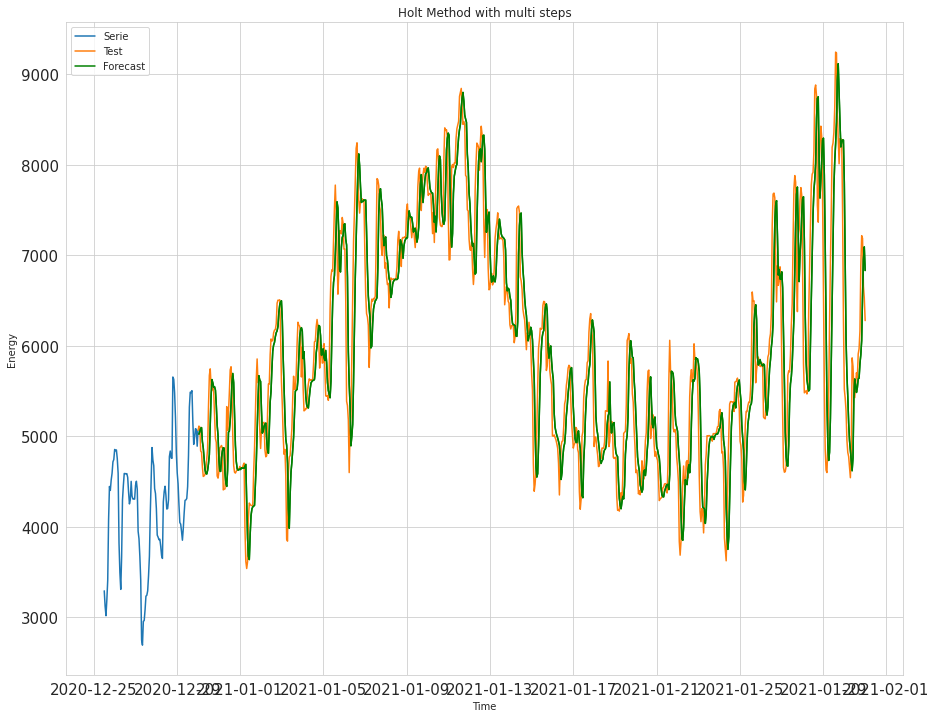

In [425]:
def simple_exp_smoothing(train, alpha, n_steps=1):
    estimated = SimpleExpSmoothing(train, initialization_method="estimated")
    _fit = estimated.fit(smoothing_level=alpha, optimized=False)
    return _fit.forecast(n_steps)

n_steps = 2
n_forecasts = len(test_vv) - n_steps + 1

for i in range(n_forecasts):
    forecast = simple_exp_smoothing(train_vv, 0.6, n_steps)
    pred.append(forecast)

    obs = test_vv[i]
    train_vv.append(obs)
    pred_exp.append([forecast[0], obs])

def evaluate_forecasts(test, forecasts, n_steps):
    sum_rmse = 0
    sum_mape = 0
    for i in range(n_steps):
        # Picking the values from multi-step forecasts
        ypred_ts = [forecast[i] for forecast in forecasts]

        # Sliding window on test series
        ytrue_ts = test[i:len(ypred_ts)+i]
        rmse = sqrt(mean_squared_error(ytrue_ts, ypred_ts))
        mape = sqrt(mean_absolute_error(ytrue_ts, ypred_ts))
        sum_rmse += rmse
        sum_mape += mape
        print(f"t+{(i+1)} RMSE: {rmse} | MAPE: {mape}")
    print(f"Média RMSE: {sum_rmse/n_steps}")
    print(f"Média MAPE: {sum_mape/n_steps}")

evaluate_forecasts(test_vv, pred, n_steps)

print("Ultimos 10 valores:")
for item in pred_exp[-10:]:
    print(f"Predito={item[0]}, Esperado={item[1]}")

fig, ax = plt.subplots(figsize=(15, 12))
ax.plot(train.index, train.values)
ax.plot(test.index, test.values, label='truth')
ax.plot(test.index[n_steps-1:], pred, color='green')
plt.legend(['Serie', 'Test', 'Forecast'])
plt.ylabel('Energy')
plt.xlabel('Time')
plt.title('Holt Method with multi steps')

## 7.2 Suavização exponencial Holt-Winter

RMSE: 293.319 | MAPE:  14
Ultimos 10 valores:
Predito=5632.536613585195, Esperado=5645.473
Predito=5615.669688089501, Esperado=5910.213
Predito=5784.426146385647, Esperado=5967.413
Predito=5956.180287978096, Esperado=6164.76
Predito=6351.46477847865, Esperado=6887.143
Predito=6964.817453414178, Esperado=7217.682
Predito=7317.571056317373, Esperado=7187.145
Predito=7221.3790700227355, Esperado=6658.727
Predito=6604.003974949404, Esperado=6529.498
Predito=6451.309472524074, Esperado=6279.152


Text(0.5, 1.0, 'Holt Winter')

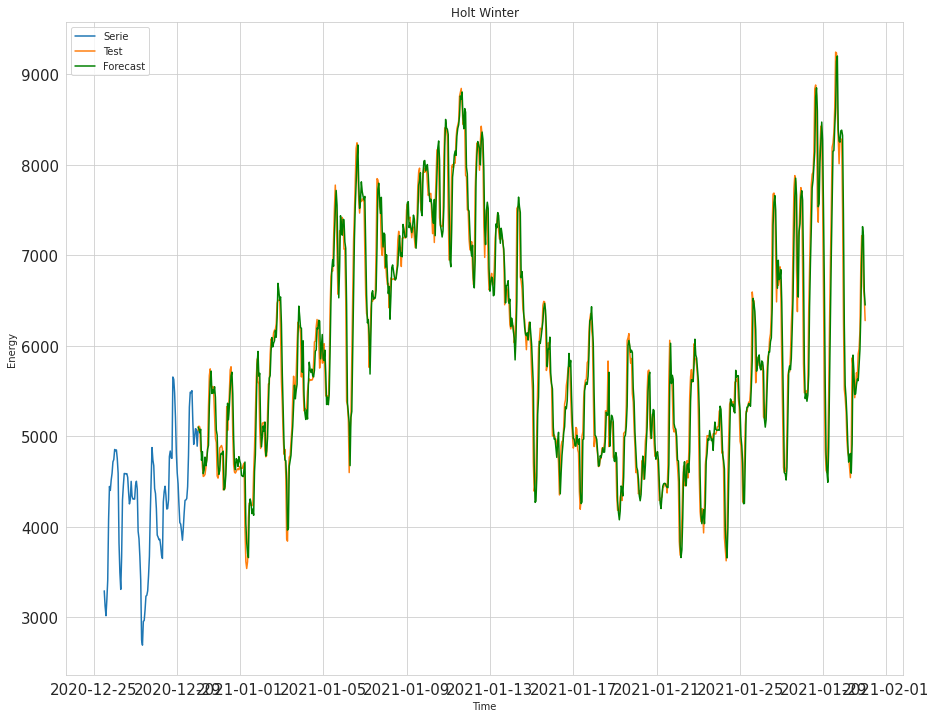

In [426]:
test_vv = test_v.values
train_vv = [x for x in train_v]

def holt_winter_method(train, n_steps=0):
    estimated = ExponentialSmoothing(train, seasonal_periods=12, trend='add', seasonal='add', use_boxcox=True, initialization_method="heuristic")
    _fit = estimated.fit(optimized=True)
    return _fit.forecast(n_steps)


pred = list()
pred_exp = list()
for i in range(len(test_vv)):
    # Predict
    forecast = holt_winter_method(train_vv)
    pred.append(forecast)

    obs = test_vv[i]
    train_vv.append(obs)
    pred_exp.append([forecast[0], obs])

rmse = sqrt(mean_squared_error(test_vv, pred))
mape = sqrt(mean_absolute_error(test_vv, pred))
print('RMSE: %.3f | MAPE: %3.f' % (rmse, mape))

print("Ultimos 10 valores:")
for item in pred_exp[-10:]:
    print(f"Predito={item[0]}, Esperado={item[1]}")

fig, ax = plt.subplots(figsize=(15, 12))
ax.plot(train.index, train.values)
ax.plot(test.index, test.values, label='truth')
ax.plot(test.index, pred, color='green')

plt.legend(['Serie', 'Test', 'Forecast'])
plt.ylabel('Energy')
plt.xlabel('Time')
plt.title('Holt Winter')